# Data prep for all training data

What follows is a notebook I used to try and recreate the features Jeremy Howard teaches [here](https://github.com/fastai/courses/blob/master/deeplearning2/rossman.ipynb) on the [Corporación Favorita Grocery Sales Forecasting](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/discussion/47185) Kaggle contest.

I would highly discourage you from trying to copy and run this code. Although I did my best to systematically document and test it at every step, I'm sure I've made occasional errors. 

I learned a ton going through it - hopefully you will as well.

In [18]:
gpu=3
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=$gpu
# libraries and utilities
%matplotlib inline
import importlib
import kevin; importlib.reload(kevin)
from kevin import *
import gfunc; importlib.reload(gfunc)
from gfunc import *
from tqdm import tqdm

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3
kevin loaded


### memory saving notes - 
1. switch objects to categories earlier.
2. save and delete older train objects when joined is created.
3. clean up rolling promo function

## paths

In [3]:
#Store in new place since all data
slowdata = data_path + 'slowdisk/'
slowdata = slowdata + 'alldata/'
results_path = results_path+'alldata/'

def save_df(df, name):
    if df.to_pickle(slowdata+name):
        return True
def load_df(name):
    return pd.read_pickle(slowdata+name)
def save_n_load_df(df, name):
    if save_df(df, name): load_df(name)
    return True
#leaves duplicate field names on left and appends with _y on right
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on=left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", "_y"))
def add_datepart(df):
#     df.date = pd.to_datetime(df.date)
    df["year"] = df.date.dt.year.astype(np.int32)
    df["month"] = df.date.dt.month.astype(np.int8)
    df["week"] = df.date.dt.week.astype(np.int8)
    df["day"] = df.date.dt.day.astype(np.int8)
    df["dayofweek"] = df.date.dt.dayofweek.astype(np.int8)
def fillna_with_zeros(df, column):
    df[column].fillna(0, inplace=True)
    df[column]=df[column].astype(np.int8)

In [13]:
results_path

'/home/kevin/nbs/kaggle/GrocerySales/results/alldata/'

## Work plan
### Data prep
1. Load data, 20% of training. chunksize = 25_000_000
2. Merge test/train datasets
1. Remove null data
3. Add columns for item, store, oil price, holiday
1. Convert dates to year mon day weekday
4. Convert labels to numbers. Change datatypes?
### Set benchmark
1. Create mean.

## Load data

In [10]:
#From:
# https://www.kaggle.com/ekami66/python-eda-with-few-interactive-graphs
# https://www.kaggle.com/jagangupta/memory-optimization-and-eda-on-entire-dataset/notebook
# https://www.kaggle.com/juanumusic/tidy-notebook-and-deep-analysis
dtypes = {'id': np.uint32,
          'store_nbr': np.uint8, 
          'item_nbr': np.uint32, 
          'unit_sales': np.float32,
          'class': np.uint16,
          'perishable': np.bool,
          'dcoilwtico':np.float16,
          'onpromotion': np.bool,
          'transactions':np.uint16,
          'cluster': np.uint32}
chunksize = 5_000_000 #5% of training set
#mid sample for data prep & checking
mid = int(chunksize/2); sample = slice(mid, mid+5)

In [11]:
#train_df
train_df = pd.read_csv(slowdata + 'train.csv', index_col='id', parse_dates=['date'], dtype=dtypes)
# all_train_df = pd.read_csv(slowdata + 'train.csv', index_col='id', parse_dates=['date'], dtype=dtypes)
# train_df=all_train_df[-chunksize:]
save_n_load_df(train_df, "training_dev.pkl")
train_df.name = "TRAINING"

/home/kevin/anaconda2/envs/ai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/kevin/anaconda2/envs/ai/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
transactions_df = pd.read_csv(slowdata + 'transactions.csv', parse_dates=['date'], dtype=dtypes)
transactions_df.name = "TRANSACTIONS"
sample_sub_df = pd.read_csv(slowdata+'sample_submission.csv')
sample_sub_df.name = "SAMPLE"
test_df = pd.read_csv(slowdata+'test.csv', dtype=dtypes, index_col='id', parse_dates=['date'])
test_df.name = "TEST"
oil_df = pd.read_csv(slowdata + 'oil.csv', parse_dates=['date'], dtype=dtypes)
oil_df.name = "OIL"
holidays_df = pd.read_csv(slowdata + 'holidays_events.csv', parse_dates=['date'], dtype=dtypes)
holidays_df.name = "HOLIDAYS"
stores_df = pd.read_csv(slowdata + 'stores.csv', dtype=dtypes)
stores_df.name = "STORES"
items_df = pd.read_csv(slowdata + 'items.csv',dtype=dtypes)
items_df.name = "ITEMS"

/home/kevin/anaconda2/envs/ai/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [375]:
# oil_df = pd.read_csv(slowdata + 'oil.csv', parse_dates=['date'], dtype=dtypes)
# oil_df.name = "OIL"
# stores_df = pd.read_csv(slowdata + 'stores.csv', dtype=dtypes)
# stores_df.name = "STORES"
# items_df = pd.read_csv(slowdata + 'items.csv',dtype=dtypes)
# items_df.name = "ITEMS"
# transactions_df = pd.read_csv(slowdata + 'transactions.csv', parse_dates=['date'], dtype=dtypes)
# transactions_df.name = "TRANSACTIONS"
# holidays_df = pd.read_csv(slowdata + 'holidays_events.csv', parse_dates=['date'], dtype=dtypes)
# holidays_df.name = "HOLIDAYS"

## View data

In [54]:
tables = [train_df, transactions_df, sample_sub_df, test_df, oil_df, holidays_df, stores_df, items_df]

In [55]:
for t in tables: display(t.name, t.head(), DataFrameSummary(t).summary())

'TRAINING'

,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
120497040,2017-06-29,35,1162935,5.0,False
120497041,2017-06-29,35,1164290,1.0,False
120497042,2017-06-29,35,1165988,2.0,False
120497043,2017-06-29,35,1166474,50.0,False
120497044,2017-06-29,35,1166475,11.0,False


,date,store_nbr,item_nbr,unit_sales,onpromotion
count,NaN,5e+06,5e+06,5e+06,NaN
mean,NaN,28.4204,1.17055e+06,8.10904,NaN
std,NaN,16.3229,586921,23.7943,NaN
min,NaN,1,96995,-274,NaN
25%,NaN,14,692105,2,NaN
50%,NaN,29,1.20972e+06,4,NaN
75%,NaN,44,1.57633e+06,8,NaN
max,NaN,54,2.12711e+06,7348,NaN
counts,5000000,5000000,5000000,5000000,5000000
uniques,48,54,3891,61385,2


'TRANSACTIONS'

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


,date,store_nbr,transactions
count,NaN,83488,83488
mean,NaN,26.9392,1694.6
std,NaN,15.6082,963.287
min,NaN,1,5
25%,NaN,13,1046
50%,NaN,27,1393
75%,NaN,40,2079
max,NaN,54,8359
counts,83488,83488,83488
uniques,1682,54,4993


'SAMPLE'

,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0


,id,unit_sales
count,3.37046e+06,3.37046e+06
mean,1.27182e+08,0
std,972969,0
min,1.25497e+08,0
25%,1.2634e+08,0
50%,1.27182e+08,0
75%,1.28025e+08,0
max,1.28868e+08,0
counts,3370464,3370464
uniques,3370464,1


'TEST'

,date,store_nbr,item_nbr,onpromotion
id,,,,
125497040,2017-08-16,1,96995,False
125497041,2017-08-16,1,99197,False
125497042,2017-08-16,1,103501,False
125497043,2017-08-16,1,103520,False
125497044,2017-08-16,1,103665,False


,date,store_nbr,item_nbr,onpromotion
count,NaN,3.37046e+06,3.37046e+06,NaN
mean,NaN,27.5,1.2448e+06,NaN
std,NaN,15.5858,589836,NaN
min,NaN,1,96995,NaN
25%,NaN,14,805321,NaN
50%,NaN,27.5,1.29466e+06,NaN
75%,NaN,41,1.73002e+06,NaN
max,NaN,54,2.13424e+06,NaN
counts,3370464,3370464,3370464,3370464
uniques,16,54,3901,2


'OIL'

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.1250
2,2013-01-03,93.0000
3,2013-01-04,93.1250
4,2013-01-07,93.1875


,date,dcoilwtico
count,NaN,1175
mean,NaN,inf
std,NaN,25.625
min,NaN,26.1875
25%,NaN,46.4062
50%,NaN,53.1875
75%,NaN,95.6562
max,NaN,110.625
counts,1218,1175
uniques,1218,704


'HOLIDAYS'

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25 00:00:00,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
first,2012-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2017-12-26 00:00:00,NaN,NaN,NaN,NaN,NaN
counts,350,350,350,350,350,350
uniques,312,6,3,24,103,2
missing,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%


'STORES'

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,city,state,type,cluster
count,NaN,NaN,NaN,54
mean,NaN,NaN,NaN,8.48148
std,NaN,NaN,NaN,4.69339
min,NaN,NaN,NaN,1
25%,NaN,NaN,NaN,4
50%,NaN,NaN,NaN,8.5
75%,NaN,NaN,NaN,13
max,NaN,NaN,NaN,17
counts,54,54,54,54
uniques,22,16,5,17


'ITEMS'

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,False
99197,GROCERY I,1067,False
103501,CLEANING,3008,False
103520,GROCERY I,1028,False
103665,BREAD/BAKERY,2712,True


,family,class,perishable
count,NaN,4100,NaN
mean,NaN,2169.65,NaN
std,NaN,1484.91,NaN
min,NaN,1002,NaN
25%,NaN,1068,NaN
50%,NaN,2004,NaN
75%,NaN,2990.5,NaN
max,NaN,7780,NaN
counts,4100,4100,4100
uniques,33,337,2


#### Merget test/train

In [13]:
#prob don't need
# last_train = train_df.iloc[-1].name
all_df = train_df.append(test_df)
# last_train

In [14]:
all_df_name='new_full_df.pkl'
save_n_load_df(all_df, all_df_name)

True

In [15]:
del(train_df); del(test_df)

#### Remove null data

In [17]:
all_df.isnull().any()
# of course ignore unit_sales since missing from test

date           False
item_nbr       False
onpromotion     True
store_nbr      False
unit_sales      True
dtype: bool

In [18]:
all_df.onpromotion.fillna(False, inplace=True)

In [ ]:
all_df['onpromotion']=all_df['onpromotion'].astype(np.int8)

In [20]:
save_n_load_df(all_df, all_df_name)

True

## Data clean / feature eng
From https://github.com/fastai/courses/blob/master/deeplearning2/rossman.ipynb

### add dateparts

In [21]:
add_datepart(all_df)

In [22]:
save_n_load_df(all_df, all_df_name)

True

### Joins

#### Oil

In [23]:
joined=join_df(all_df, oil_df, 'date')

In [50]:
joined['dcoilwtico'].interpolate(inplace=True, limit_direction='both')

In [52]:
#make ints to simplify
joined['dcoilwtico']=joined['dcoilwtico'].astype(np.int8)

In [54]:
save_n_load_df(joined, 'oil_joined.pkl')

True

### Stores

In [55]:
joined=join_df(joined, stores_df, 'store_nbr')

In [56]:
save_n_load_df(joined, 'joined_stores.pkl')

True

#### Items

In [57]:
joined=join_df(joined, items_df, 'item_nbr')

In [58]:
save_n_load_df(joined, 'joined_items.pkl')

True

### Transactions

In [59]:
joined = join_df(joined, transactions_df, ['date', 'store_nbr'])

In [61]:
save_n_load_df(joined, 'joined_transactions.pkl')

True

#### HOliday

##### todo

1. Add boolean loc_hol, reg_hol, nat_hol columns to holidays_df
1. Add city, state to holiday_df based on locale_name
1. merge local_hol with joined on date, city
1. merge regional_hol with joined on date, state
1. merge nat_hol with joined on date

##### todo
1. go back and check the holiday rules to see if these are actually correct

#Local non-Holiday types are all holiday_like. Allows us to set cities['local_hol']=1 below
ph.loc[(ph['locale']=='Local') & (ph['type']!='Holiday')]['type'].value_counts()

#All regional are type Holiday. Allows us to set cities['local_hol']=1 below
ph.loc[(ph['locale']=='Regional')]['type'].value_counts()

#### Generate mergable holidays table

In [62]:
#Using the locale_name to identify cities and states. Then we can merge with joined table.
#Effectively ignoring locale Local and Regional since they don't align perfectly with either.
#from https://www.kaggle.com/c/favorita-grocery-sales-forecasting/data
holiday_like = ['Holiday', 'Additional', 'Transfer', 'Bridge']
#copy of holiday df for data wrangling
ph=holidays_df.copy()
#cities, Local
cities = stores_df[['city']].drop_duplicates() 
cities['locale_name'] = cities['city']
cities['city_hol']=1
ph=join_df(ph,cities, 'locale_name')
#states, Regional
states = stores_df[['state']].drop_duplicates() 
states['locale_name'] = states['state']
states['state_hol']=1
ph=join_df(ph,states, 'locale_name')
#cleanup
for p in ['city_hol', 'state_hol']:
    ph[p].fillna(0, inplace=True)
    ph[p]=ph[p].astype(np.int8)
#National holiday and events. More complex, must check for holiday_like
ph['nat_hol']=ph.apply(lambda row: row['locale']=='National' and row['type'] in holiday_like, axis=1).astype(np.int8)
ph['nat_event']=ph.apply(lambda row:row['type']=='Event', axis=1).astype(np.int8)
#TODO - Consider adding descriptions of holidays

In [63]:
save_n_load_df(ph, 'mergeable_holidays.pkl')
# ph = load_df('mergeable_holidays.pkl')

True

In [ ]:
display(DataFrameSummary(ph).summary(), ph.info(), ph.head())

In [65]:
city_holidays_df = ph.loc[ph['city_hol']==1, ['date', 'city', 'city_hol']].copy().reset_index(drop=True)
state_holidays_df = ph.loc[ph['state_hol']==1, ['date', 'state', 'state_hol']].copy().reset_index(drop=True)
nat_holidays_df = ph.loc[ph['nat_hol']==1, ['date', 'nat_hol']].copy().reset_index(drop=True)
nat_events_df = ph.loc[ph['nat_event']==1, ['date', 'nat_event']].copy().reset_index(drop=True)

#### Merge with joined

In [66]:
joined = load_df('joined_transactions.pkl')

##### city holidays

In [71]:
city_holidays_df.head()

,date,city,city_hol
0,2012-03-02,Manta,1
1,2012-04-12,Cuenca,1
2,2012-04-14,Libertad,1
3,2012-04-21,Riobamba,1
4,2012-05-12,Puyo,1


In [67]:
joined=join_df(joined, city_holidays_df, ['date', 'city'])

In [68]:
fillna_with_zeros(joined, 'city_hol')

In [69]:
chk = joined.loc[joined['city_hol']==1]

In [76]:
holidays_df.loc[holidays_df['date']==chk.head()['date'].iloc[0]].head()

,date,type,locale,locale_name,description,transferred
47,2013-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


##### State holidays

In [72]:
joined=join_df(joined, state_holidays_df, ['date', 'state'])

In [73]:
fillna_with_zeros(joined, 'state_hol')

In [74]:
chk = joined.loc[joined['state_hol']==1]
holidays_df.loc[holidays_df['date']==chk.head()['date'].iloc[0]].head()

,date,type,locale,locale_name,description,transferred
47,2013-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [77]:
stores_df[['state']].drop_duplicates()

,state
0,Pichincha
4,Santo Domingo de los Tsachilas
11,Cotopaxi
13,Chimborazo
14,Imbabura
18,Bolivar
21,Pastaza
22,Tungurahua
23,Guayas
24,Santa Elena


##### Nat holidays and events

In [78]:
joined=join_df(joined, nat_holidays_df, 'date')
joined=join_df(joined, nat_events_df, 'date')

In [79]:
fillna_with_zeros(joined, 'nat_hol')
fillna_with_zeros(joined, 'nat_event')

In [80]:
chk = joined.loc[joined['nat_hol']==1].head(); chk

,date,item_nbr,onpromotion,store_nbr,unit_sales,year,month,week,day,dayofweek,...,type,cluster,family,class,perishable,transactions,city_hol,state_hol,nat_hol,nat_event
0,2013-01-01,103665,False,25,7.0,2013,1,1,1,1,...,D,1,BREAD/BAKERY,2712,True,770.0,0,0,1,0
1,2013-01-01,105574,False,25,1.0,2013,1,1,1,1,...,D,1,GROCERY I,1045,False,770.0,0,0,1,0
2,2013-01-01,105575,False,25,2.0,2013,1,1,1,1,...,D,1,GROCERY I,1045,False,770.0,0,0,1,0
3,2013-01-01,108079,False,25,1.0,2013,1,1,1,1,...,D,1,GROCERY I,1030,False,770.0,0,0,1,0
4,2013-01-01,108701,False,25,1.0,2013,1,1,1,1,...,D,1,DELI,2644,True,770.0,0,0,1,0


In [81]:
holidays_df.loc[holidays_df['date']==chk.head()['date'].iloc[0]].head()

,date,type,locale,locale_name,description,transferred
41,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False


In [82]:
#Have to run later, no national events in training set
chk = joined.loc[joined['nat_event']==1].head()
holidays_df.loc[holidays_df['date']==chk.head()['date'].iloc[0]].head()

,date,type,locale,locale_name,description,transferred
54,2013-05-12,Holiday,Local,Puyo,Cantonizacion del Puyo,False
55,2013-05-12,Event,National,Ecuador,Dia de la Madre,False


In [83]:
save_n_load_df(joined, 'joined_holidays.pkl')

True

### Calculate time durations

#### 30-day percentage oil change

In [84]:
dates=joined['date'].drop_duplicates(); dates[0]

Timestamp('2013-01-01 00:00:00')

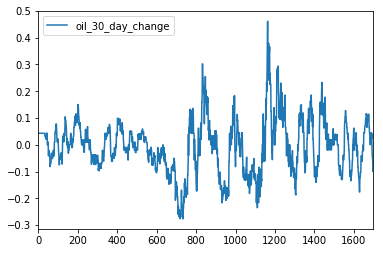

In [87]:
oil_prices = joined[['date', 'dcoilwtico']].copy().drop_duplicates(['date']).reset_index(drop=True)
oil_prices['oil_30_day_change'] = oil_prices['dcoilwtico'].pct_change(periods=30).fillna(method='bfill')
oil_prices[['date', 'oil_30_day_change']].plot()

In [88]:
oil_prices.drop(labels='dcoilwtico', axis=1, inplace=True)

In [89]:
joined=join_df(joined, oil_prices, 'date')

In [90]:
save_n_load_df(joined, 'joined_30_day_oil.pkl')

True

#### Elapsed since events

In [92]:
# joined = load_df('joined_30_day_oil.pkl')

In [93]:
columns=['date', 'store_nbr', 'state_hol', 'city_hol', 'nat_hol', 'nat_event']

In [94]:
#clean up, using last_store and store_nbr
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.store_nbr != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.store_nbr
        if (row[self.fld]): self.last = row.date
        return row.date-self.last

def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [95]:
df=joined[columns].copy()
df.drop_duplicates(inplace=True)

## Begin samp test to see if this code works

def add_elapsed_samp(fld, prefix):
    sh_el = elapsed(fld)
    samp[prefix+fld] = samp.apply(sh_el.get, axis=1)

samp=pd.concat([df[0:5]]*5).reset_index(drop=True)
samp.iloc[5:10]['date'] = samp.iloc[0].date + pd.DateOffset(1)
samp.iloc[10:15]['date'] = samp.iloc[0].date + pd.DateOffset(2)
samp.iloc[15:20]['date'] = samp.iloc[0].date + pd.DateOffset(3)
samp.iloc[20:25]['date'] = samp.iloc[0].date + pd.DateOffset(4)
samp=samp.sort_values(['store_nbr', 'date'])
samp.set_value(10, 'state_hol', 1)
samp.set_value(12, 'city_hol', 1)
samp.set_value(17, 'city_hol', 1)
samp.set_value(22, 'city_hol', 1)
samp.set_value(6, 'nat_hol', 1)
samp.set_value(13, 'nat_event', 1)

for fld in holidays:
    add_elapsed_samp(fld, 'after_')
samp = samp.sort_values(['store_nbr', 'date'], ascending=[True, False])
for fld in holidays:
    add_elapsed_samp(fld, 'before_')
hol_dur = [o+p for o in ['before_', 'after_'] for p in holidays]
for a in hol_dur:
    samp[a]=samp[a].fillna(pd.Timedelta(0)).dt.days
samp

samp = samp.set_index('date')

bwd = samp[['store_nbr']+ holidays].sort_index().groupby('store_nbr').rolling(7, min_periods=1).sum()
fwd = samp[['store_nbr']+ holidays].sort_index(ascending=False).groupby('store_nbr').rolling(7, min_periods=1).sum()

bwd

bwd.drop('store_nbr', 1, inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('store_nbr', 1, inplace=True)
fwd.reset_index(inplace=True)

samp.reset_index(inplace=True)
samp=samp.merge(bwd, 'left', ['date', 'store_nbr'], suffixes=['', '_bw'])
samp=samp.merge(fwd, 'left', ['date', 'store_nbr'], suffixes=['', '_fw'])

samp[['date','store_nbr', 'city_hol', 'city_hol_fw']]

## End samp test, seems fine

fld='state_hol'
df=df.sort_values(['store_nbr', 'date'])
add_elapsed(fld, 'after')
#df=df.sort_values(['store_nbr', 'date'], ascending=[True, False])
#add_elapsed(fld, 'before')

In [96]:
holidays=['state_hol', 'city_hol', 'nat_hol', 'nat_event']

In [97]:
df=df.sort_values(['store_nbr', 'date'])

In [98]:
for fld in tqdm(holidays):
    add_elapsed(fld, 'after_')

100%|██████████| 4/4 [00:42<00:00, 10.79s/it]


In [99]:
df=df.sort_values(['store_nbr', 'date'], ascending=[True, False])

In [100]:
for fld in tqdm(holidays):
    add_elapsed(fld, 'before_')

100%|██████████| 4/4 [00:49<00:00, 12.34s/it]


In [101]:
save_n_load_df(df, 'elapsed_events_df.pkl')

True

In [327]:
# df=load_df('elapsed_events_df.pkl')

In [102]:
hol_dur = [o+p for o in ['before_', 'after_'] for p in holidays]

In [329]:
#since there are no nat_event
#don't run on full dataframe later!!!!
# df['after_nat_event']=pd.Series([0 for x in range(len(df.index))], index=df.index)
# df['before_nat_event']=pd.Series([0 for x in range(len(df.index))], index=df.index)
# hol_dur.remove('after_nat_event')
# hol_dur.remove('before_nat_event')

In [103]:
for a in tqdm(hol_dur):
    df[a]=df[a].fillna(pd.Timedelta(0)).dt.days

100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


In [104]:
save_n_load_df(df, 'filled_elapsed_events_df.pkl')

True

##### Now rolling windows

In [333]:
# df = load_df('filled_elapsed_events_df.pkl')

In [105]:
df=df.set_index('date')

In [106]:
bwd = df[['store_nbr']+ holidays].sort_index().groupby('store_nbr').rolling(7, min_periods=1).sum()
fwd = df[['store_nbr']+ holidays].sort_index(ascending=False).groupby('store_nbr').rolling(7, min_periods=1).sum()

In [107]:
bwd.drop('store_nbr', 1, inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('store_nbr', 1, inplace=True)
fwd.reset_index(inplace=True)

In [108]:
df.reset_index(inplace=True)
df=df.merge(bwd, 'left', ['date', 'store_nbr'], suffixes=['', '_bw'])
df=df.merge(fwd, 'left', ['date', 'store_nbr'], suffixes=['', '_fw'])

In [109]:
df.drop(holidays, 1, inplace=True)

In [110]:
save_n_load_df(df, 'rolled_filled_elapsed_events_df.pkl')

True

In [111]:
# df=load_df('rolled_filled_elapsed_events_df.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84470 entries, 0 to 84469
Data columns (total 18 columns):
date                84470 non-null datetime64[ns]
store_nbr           84470 non-null uint8
after_state_hol     84470 non-null int64
after_city_hol      84470 non-null int64
after_nat_hol       84470 non-null int64
after_nat_event     84470 non-null int64
before_state_hol    84470 non-null int64
before_city_hol     84470 non-null int64
before_nat_hol      84470 non-null int64
before_nat_event    84470 non-null int64
state_hol_bw        84470 non-null float64
city_hol_bw         84470 non-null float64
nat_hol_bw          84470 non-null float64
nat_event_bw        84470 non-null float64
state_hol_fw        84470 non-null float64
city_hol_fw         84470 non-null float64
nat_hol_fw          84470 non-null float64
nat_event_fw        84470 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(8), uint8(1)
memory usage: 11.7 MB


##### Cleanup to save memory on merge

In [112]:
cols=df.columns.tolist()
cols.remove('date')
cols.remove('store_nbr')

In [113]:
for c in cols: df[c]=df[c].astype(np.int16)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84470 entries, 0 to 84469
Data columns (total 18 columns):
date                84470 non-null datetime64[ns]
store_nbr           84470 non-null uint8
after_state_hol     84470 non-null int16
after_city_hol      84470 non-null int16
after_nat_hol       84470 non-null int16
after_nat_event     84470 non-null int16
before_state_hol    84470 non-null int16
before_city_hol     84470 non-null int16
before_nat_hol      84470 non-null int16
before_nat_event    84470 non-null int16
state_hol_bw        84470 non-null int16
city_hol_bw         84470 non-null int16
nat_hol_bw          84470 non-null int16
nat_event_bw        84470 non-null int16
state_hol_fw        84470 non-null int16
city_hol_fw         84470 non-null int16
nat_hol_fw          84470 non-null int16
nat_event_fw        84470 non-null int16
dtypes: datetime64[ns](1), int16(16), uint8(1)
memory usage: 3.9 MB


In [114]:
joined=join_df(joined, df, ['date', 'store_nbr'])

In [115]:
save_n_load_df(joined, 'joined_elapsed_events.pkl')

True

In [117]:
joined['onpromotion'].value_counts()

False    121027360
True       8026704
Name: onpromotion, dtype: int64

#### Promotion durations
Promotions are unique to date, item and store

In [3]:
joined=load_df('joined_elapsed_events.pkl')

In [4]:
promo_df = joined[['date', 'item_nbr', 'store_nbr', 'onpromotion']].copy()

In [5]:
#future - look at ways to speed up or free up memory by deleting objects.
class itm_elapsed(object):
    def __init__(self, fld, total):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store_nbr = 0
        self.last_item_nbr = 0
        self.count=0
        self.total=total
        
    def get(self, row):
        self.count+=1
        if (not self.count % 1e6):
            print('Another 1 million out of {}'.format(self.total))
        if (row.item_nbr != self.last_item_nbr) or (row.store_nbr != self.last_store_nbr):
            self.last = pd.to_datetime(np.nan)
            self.last_item_nbr = row.item_nbr
            self.last_store_nbr = row.store_nbr
        if (row[self.fld]): self.last = row.date
        return row.date-self.last

def itm_add_elapsed(fld, prefix):
    sh_el = itm_elapsed(fld, total=len(promo_df)//1e6)
    promo_df[prefix+fld] = promo_df.apply(sh_el.get, axis=1)

In [7]:
del(joined)

NameError: name 'joined' is not defined

In [9]:
promo_df['onpromotion']=promo_df['onpromotion'].astype(np.int8)

In [11]:
save_n_load_df(promo_df, 'promo_df1.pkl')

True

In [12]:
promo_df.sort_values(['item_nbr','store_nbr', 'date'], inplace=True)

In [13]:
save_n_load_df(promo_df, 'promo_df2.pkl')

True

In [14]:
itm_add_elapsed('onpromotion', 'after_')

Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 

In [15]:
save_n_load_df(promo_df, 'promo_df3.pkl')

True

In [16]:
promo_df.sort_values(['item_nbr','store_nbr', 'date'], ascending=[True, True, False], inplace=True)

In [17]:
save_n_load_df(promo_df, 'promo_df4.pkl')

True

In [18]:
itm_add_elapsed('onpromotion', 'before_')

Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 1 million out of 129.0
Another 

In [19]:
save_n_load_df(promo_df, 'promo_df5.pkl')

True

In [ ]:
# promo_df = load_df('promo_df_elapsed.pkl')

In [20]:
promo_df['after_onpromotion']=promo_df['after_onpromotion'].fillna(pd.Timedelta(0)).dt.days
promo_df['before_onpromotion']=promo_df['before_onpromotion'].fillna(pd.Timedelta(0)).dt.days

In [145]:
promo_df['after_onpromotion'].value_counts()

0     6215995
1      234142
2      201832
3      192847
4      188255
5      183151
6      179268
8       48578
10      46766
9       46486
11      46133
12      45193
13      43937
7       43304
15      34913
14      34053
16      23446
17      23149
18      23030
19      22483
20      22337
21      20539
22      20436
24      19822
25      19760
23      19734
26      19354
27      19260
28      18386
29      18189
       ...   
34      14332
35      13899
36      13742
37      11951
38      11593
39      11558
40      11279
41      11049
42      10931
43      10406
44      10264
45      10140
47      10106
46      10106
48       9836
49       9611
50       9410
51       6705
52       6182
53       5780
54       4854
55       4560
56       4272
57       4045
58       2000
59       1489
60       1212
61        995
62        753
63        142
Name: after_onpromotion, Length: 64, dtype: int64

In [21]:
promo_df['after_onpromotion'] = promo_df['after_onpromotion'].astype(np.int16)
promo_df['before_onpromotion'] = promo_df['before_onpromotion'].astype(np.int16)

In [22]:
save_n_load_df(promo_df, 'promo_df6.pkl')

True

#### Future - add rolling for onpromotion

In [23]:
promo_df.drop('onpromotion', 1, inplace=True)

In [24]:
joined=load_df('joined_elapsed_events.pkl')

In [25]:
joined=join_df(joined, promo_df, ['date', 'store_nbr', 'item_nbr'])

In [34]:
del(promo_df)

NameError: name 'promo_df' is not defined

In [26]:
save_n_load_df(joined, 'joined_promo_bef_af.pkl')

True

In [28]:
joined['onpromotion']=joined['onpromotion'].astype(np.int8)

In [29]:
joined['oil_30_day_change']=joined['oil_30_day_change'].astype(np.float32)
joined['transactions']=joined['transactions'].astype(np.float32)

In [30]:
save_n_load_df(joined, 'joined_promo_bef_af2.pkl')

True

## Rolling transactions

In [92]:
joined=load_df('joined_promo_bef_af2.pkl')

In [93]:
trans = joined[['date', 'store_nbr','transactions']].drop_duplicates()
trans.set_index('date', inplace=True)

In [94]:
roll_17=trans.sort_index().groupby('store_nbr').rolling(17,
    min_periods=1).mean().rename(columns={'transactions': 'tr_roll_17'}).astype(np.int16)
roll_90=trans.sort_index().groupby('store_nbr').rolling(90,
    min_periods=1).mean().rename(columns={'transactions': 'tr_roll_90'}).astype(np.int16)
roll_360=trans.sort_index().groupby('store_nbr').rolling(360,
    min_periods=1).mean().rename(columns={'transactions': 'tr_roll_360'}).astype(np.int16)

In [95]:
for dfr in [roll_17, roll_90, roll_360]:
    dfr.drop('store_nbr', 1, inplace=True)
    dfr.reset_index(inplace=True) 

In [96]:
tr_roll = roll_17.merge(roll_90, 'left', ['date', 'store_nbr']).merge(roll_360, 'left', ['date', 'store_nbr'])

In [97]:
joined = joined.merge(tr_roll, 'left', ['date', 'store_nbr'])

In [98]:
if save_n_load_df(joined, 'joined_roll_tran.pkl'): del(tr_roll)

## Create features for NN

#### Future - not sure how to deal with transactions. Perhaps predict both sales and transactions in model?

In [41]:
cls = joined.columns.tolist()

['date',
 'item_nbr',
 'onpromotion',
 'store_nbr',
 'unit_sales',
 'year',
 'month',
 'week',
 'day',
 'dayofweek',
 'dcoilwtico',
 'city',
 'state',
 'type',
 'cluster',
 'family',
 'class',
 'perishable',
 'transactions',
 'state_hol',
 'city_hol',
 'nat_hol',
 'nat_event',
 'oil_30_day_change',
 'after_state_hol',
 'after_city_hol',
 'after_nat_hol',
 'after_nat_event',
 'before_state_hol',
 'before_city_hol',
 'before_nat_hol',
 'before_nat_event',
 'state_hol_bw',
 'city_hol_bw',
 'nat_hol_bw',
 'nat_event_bw',
 'state_hol_fw',
 'city_hol_fw',
 'nat_hol_fw',
 'nat_event_fw',
 'after_onpromotion',
 'before_onpromotion']

In [36]:
cat_var_dict = {'item_nbr': 50,
                'onpromotion': 3,
                'store_nbr': 25, 
                'year': 3,
                'month': 6,
                'week': 6,
                'day': 10,
                'dayofweek': 10,
                'city': 10,
                'state': 10,
                'type': 5,
                'cluster': 10,
                'family': 15,
                'class': 20,
                'perishable': 5,
                'state_hol': 3,
                'city_hol': 3,
                'nat_hol': 3,
                'nat_event': 3,
                'state_hol_bw': 2,
                'city_hol_bw': 2,
                'nat_hol_bw': 2,
                'nat_event_bw': 2,
                'state_hol_fw': 2,
                'city_hol_fw': 2,
                'nat_hol_fw': 2,
                'nat_event_fw': 2}

In [37]:
pickle.dump(cat_var_dict, open(slowdata + 'cat_var_dict.pkl', 'wb'))
cat_var_dict = pickle.load(open(slowdata + 'cat_var_dict.pkl', 'rb'))

In [38]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=lambda x: x[1], reverse=True)]

In [99]:
contin_vars = ['dcoilwtico',
               'oil_30_day_change',
               'after_state_hol',
               'after_city_hol',
               'after_nat_hol',
               'after_nat_event',
               'before_state_hol',
               'before_city_hol',
               'before_nat_hol',
               'before_nat_event',
               'after_onpromotion',
               'before_onpromotion',
               'tr_roll_17',
              'tr_roll_90',
              'tr_roll_360']

In [42]:
#check, should miss date, unit_sales, transactions
len(cls) ==  len(cat_var_dict) + len(contin_vars) + 3

True

In [100]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

In [45]:
cat_mapper = DataFrameMapper(cat_maps)m
cat_cols = len(cat_map_fit.features); cat_cols

27

In [101]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features); contin_cols

/home/kevin/anaconda2/envs/ai/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/kevin/anaconda2/envs/ai/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


15

In [102]:
pickle.dump(contin_map_fit, open(slowdata + 'contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open(slowdata + 'cat_maps.pickle', 'wb'))

In [48]:
contin_map_fit = pickle.load(open(slowdata + 'contin_maps.pickle', 'rb'))
cat_map_fit = pickle.load(open(slowdata + 'cat_maps.pickle', 'rb'))

## Split training/test

In [103]:
len(joined)

129427184

In [104]:
joined_train_df = joined[joined.unit_sales.notnull()]

In [105]:
len(joined_train_df)

126056720

In [106]:
joined_test_df = joined[joined.unit_sales.isnull()]

In [107]:
len(joined_train_df)+len(joined_test_df)==len(joined)

True

In [108]:
joined_train_df.to_pickle(slowdata+'joined_train_df.pkl')
joined_test_df.to_pickle(slowdata+'joined_test_df.pkl')

In [55]:
joined_train_df = pd.read_pickle(slowdata+'joined_train_df.pkl')
joined_test_df = pd.read_pickle(slowdata+'joined_test_df.pkl')

## Load data code

In [2]:
slowdata = data_path + 'slowdisk/'
slowdata = slowdata + 'alldata/'
results_path = results_path+'alldata/'
joined_train_df = pd.read_pickle(slowdata+'joined_train_df.pkl')
joined_test_df = pd.read_pickle(slowdata+'joined_test_df.pkl')
contin_map_fit = pickle.load(open(slowdata + 'contin_maps.pickle', 'rb'))
cat_map_fit = pickle.load(open(slowdata + 'cat_maps.pickle', 'rb'))
cat_var_dict = pickle.load(open(slowdata + 'cat_var_dict.pkl', 'rb'))

## Split train/valid

In [3]:
train_ratio = 0.95
train_size = int(train_ratio*len(joined_train_df))
joined_train = joined_train_df[:train_size]
joined_valid = joined_train_df[train_size:]
len(joined_train)+len(joined_valid)==len(joined_train_df)

True

## Sample Weights

In [4]:
#from rules, perishable weighted as 1.25
sample_weight = np.array([1 if not p else 1.25 for p in joined_train.perishable])

In [8]:
pickle.dump(sample_weight, open(slowdata + 'sample_weight.pkl', 'wb'))

## Preprocess

In [15]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int16)
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [6]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)
cat_map_test = cat_preproc(joined_test_df)

In [22]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)
contin_map_test = contin_preproc(joined_test_df)
contin_cols=contin_map_train.shape[1]

In [23]:
pickle.dump(cat_map_train, open(slowdata + 'cat_map_train.pkl', 'wb'), protocol=4)
pickle.dump(cat_map_valid, open(slowdata + 'cat_map_valid.pkl', 'wb'))
pickle.dump(contin_map_train, open(slowdata + 'contin_map_train.pkl', 'wb'), protocol=4)
pickle.dump(contin_map_valid, open(slowdata + 'contin_map_valid.pkl', 'wb'))
pickle.dump(cat_map_test, open(slowdata + 'cat_map_test.pkl', 'wb'))
pickle.dump(contin_map_test, open(slowdata + 'contin_map_test.pkl', 'wb'))
pickle.dump(contin_cols, open(slowdata + 'contin_cols.pkl', 'wb'))

In [16]:
save_df(joined_train, 'join_train_all.pkl')
save_df(joined_valid, 'joined_valid_all.pkl')

## Load training data

In [19]:
cat_map_train = pickle.load(open(slowdata + 'cat_map_train.pkl', 'rb'))
cat_map_valid = pickle.load(open(slowdata + 'cat_map_valid.pkl', 'rb'))
contin_map_train = pickle.load(open(slowdata + 'contin_map_train.pkl', 'rb'))
contin_map_valid = pickle.load(open(slowdata + 'contin_map_valid.pkl', 'rb'))
sample_weight = pickle.load(open(slowdata + 'sample_weight.pkl', 'rb'))
cat_map_fit = pickle.load(open(slowdata + 'cat_maps.pickle', 'rb'))
contin_map_fit = pickle.load(open(slowdata + 'contin_maps.pickle', 'rb'))
cat_var_dict = pickle.load(open(slowdata + 'cat_var_dict.pkl', 'rb'))
cat_map_test = pickle.load(open(slowdata + 'cat_map_test.pkl', 'rb'))
contin_map_test = pickle.load(open(slowdata + 'contin_map_test.pkl', 'rb'))
contin_cols = pickle.load(open(slowdata + 'contin_cols.pkl', 'rb'))
joined_train = load_df('join_train_all.pkl')
joined_valid = load_df('joined_valid_all.pkl')

## Create model data

In [20]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]
map_test = split_cols(cat_map_test) + [contin_map_test]

In [24]:
meany_train, stdevy_train, y_train = normy(joined_train.as_matrix(columns = ['unit_sales']))
meany_valid, stdevy_valid, y_valid = normy(joined_valid.as_matrix(columns = ['unit_sales']))

#remove normalization
y_train = joined_train.as_matrix(columns = ['unit_sales'])
y_valid = joined_valid.as_matrix(columns = ['unit_sales'])

## Save model data

In [26]:
pickle.dump(map_train, open(slowdata + 'map_train.pkl', 'wb'), protocol=4)
pickle.dump(map_valid, open(slowdata + 'map_valid.pkl', 'wb'))
pickle.dump(map_test, open(slowdata + 'map_test.pkl', 'wb'))

pickle.dump(meany_train, open(slowdata + 'meany_train.pkl', 'wb'))
pickle.dump(stdevy_train, open(slowdata + 'stdevy_train.pkl', 'wb'))
pickle.dump(y_train, open(slowdata + 'y_train.pkl', 'wb'))
pickle.dump(meany_valid, open(slowdata + 'meany_valid.pkl', 'wb'))
pickle.dump(stdevy_valid, open(slowdata + 'stdevy_valid.pkl', 'wb'))
pickle.dump(y_valid, open(slowdata + 'y_valid.pkl', 'wb'))

## Load model data

In [28]:
cat_var_dict = pickle.load(open(slowdata + 'cat_var_dict.pkl', 'rb'))
contin_cols = pickle.load(open(slowdata + 'contin_cols.pkl', 'rb'))
cat_map_fit = pickle.load(open(slowdata + 'cat_maps.pickle', 'rb'))

map_train = pickle.load(open(slowdata + 'map_train.pkl', 'rb'))
map_valid = pickle.load(open(slowdata + 'map_valid.pkl', 'rb'))
map_test = pickle.load(open(slowdata + 'map_test.pkl', 'rb'))

sample_weight = pickle.load(open(slowdata + 'sample_weight.pkl', 'rb'))

meany_train = pickle.load(open(slowdata + 'meany_train.pkl', 'rb'))
stdevy_train = pickle.load(open(slowdata + 'stdevy_train.pkl', 'rb'))
y_train = pickle.load(open(slowdata + 'y_train.pkl', 'rb'))
meany_valid = pickle.load(open(slowdata + 'meany_valid.pkl', 'rb'))
stdevy_valid = pickle.load(open(slowdata + 'stdevy_valid.pkl', 'rb'))
y_valid = pickle.load(open(slowdata + 'y_valid.pkl', 'rb'))

In [29]:
rec_mem()